#### <strong>第二次作品：SVD 與影像特徵實驗</strong>
學號：711233117

姓名：楊廷紳
<hr>

 <font color=skyblue>作品目標</font>：理解 SVD（奇異值分解）的原理與應用。 SVD 可以幫助將高維度的資料壓縮到低維度空間中，同時保留資料的主要特徵。這在圖像壓縮、語音訊號壓縮等領域有廣泛的應用。透過 SVD，可以將資料降維到較低的維度，同時盡量保留原始資料的信息。這對於處理高維度資料、減少計算複雜度以及視覺化資料等都非常有用。本作品透過影像處理壓縮、切割影像，學習 SVD 原理及不同影像資料的應用方式。

<font color = yellow> 載入相關套件 <font>

In [155]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import fetch_openml
import pandas as pd
import scipy.io
import skimage.util as skutil

<hr>

### **第一題**

將一張圖像 X 利用 SVD 的 “Rank q approximation”，能達到壓縮的目的並保持圖像的品質。比較下列幾種對於圖像矩陣 X 的重組安排，並進行 “Rank q approximation”，在同樣的壓縮比之下，觀察還原後的圖像品質哪個最好？能說出理由嗎？

<font color = yellow> 原圖檔輸入，並將彩圖轉化為黑白。圖檔大小為 512*512，色階為 3，代表為 R、G、B三原色，這裡必須把色階拿掉，在進行矩陣計算時比較方便。 <font>

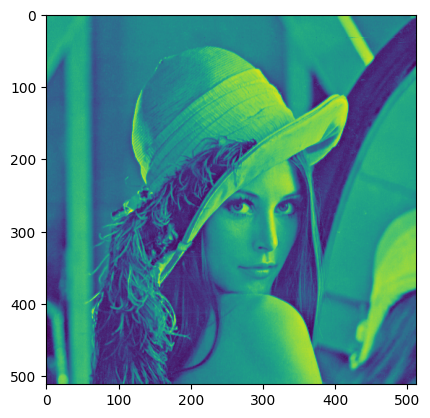

In [156]:
imgfile = 'D:\shallow_ml\pictures\lenna.png' # 512x512x3 (512為大小，3:R,G,B)
X = mpimg.imread(imgfile)
#plt.imshow(X) # 當前圖呈現 該圖為原圖

if len(X.shape) > 2: # convert RGB to grayscale 兩個以上為彩圖，轉化為黑白
    X = np.mean(X, axis=2) 
plt.imshow(X)

<font color = yellow> 原圖為 X ，先獲取 X 的行列數後，進行奇異值分解獲取左奇異矩陣、奇異值數列、右奇異矩陣。q 個主成分會由 p 列以下的數字決定。 SVD 的步驟可視為影像壓縮，而 U[:, :r] @ np.diag(E[:r]) @ VT[:r, :] 為還原的圖像 Xq 。<font>

 1. X 不變

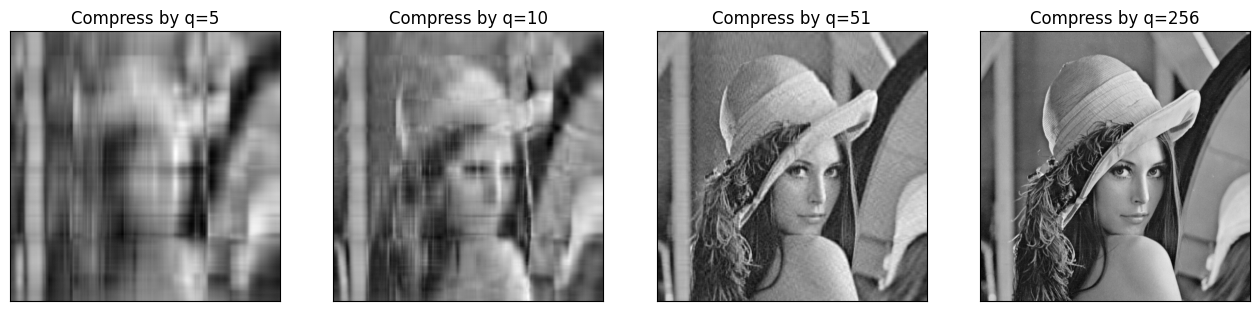

In [157]:
N, p = X.shape # 圖行與列
U, E, VT = svd(X, full_matrices = False) # 做svd分解，分為左奇異矩陣、奇異值數列、右奇異矩陣
q=np.array([p/100,p/50,p/10,p/2]).astype('int') # 分別取 5、10、51、256 個主成分

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, r in enumerate(q): # 影像壓縮
    # 欄 @ 對角矩陣 @ 列
    Xq = U[:, :r] @ np.diag(E[:r]) @ VT[:r, :] # Xq 為重新組成的圖片
    ax[i].imshow(Xq, cmap = 'gray')
    ax[i].set_title('Compress by q={}'.format(r))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

 2. 將 X 以 8 $\times$ 8 小圖（patch）進行切割，再將每個小圖拉成 64 $\times$ 1 的向量，最後重組這些向量並排成新的 64 $\times$ N 矩陣。

In [158]:
def montage(A, m, n): #原始像素矩陣 A 中的 N 張圖像排列成一個 m 行 n 列的拼貼矩陣 M
    '''
    Create a montage matrix with mn images
    Inputs:
    A: original pxN image matrix with N images (p pixels), N > mn
    m, n: m rows & n columns, total mn images
    Output:
    M: montage matrix containing mn images  
    '''
    # 首先計算出圖像的大小，假設每張圖像都是正方形，因此透過 A.shape[0] 取得單張圖像的像素數，然後取其平方根，得到每張圖像的邊長。
    sz = np.sqrt(A.shape[0]).astype('int') # astype('int') 確保結果是整數型態。
    M = np.zeros((m*sz, n*sz)) # 創建一個全零的拼貼矩陣 M，其大小為 msz 行、nsz 列，這是為了容納 mn 張圖像，每張圖像大小為 szsz。
    for i in range(m) :
        for j in range(n) :
            M[i*sz: (i+1)*sz, j*sz:(j+1)*sz] = A[:, i*n+j].reshape(sz, sz)
    return M
    #總結:將一個包含 N 張圖像的像素矩陣 A，重新排列成一個 m 行 n 列的拼貼矩陣 M，其中每張圖像都以相同大小的正方形子區域呈現。

<font color = yellow> 先將原圖切為想要的區塊，第二小題每個區塊 (patch) 切成 8*8 ，並以此區塊為範圍滑動 8 步到下個區塊對原圖進行切割。建立空陣列 M ，將剛才所切割的所有小區塊放入 M 先重組，再進行 SVD 分解與還原影像。 <font>

In [159]:
def compress_and_show_image(imgfile, patch_sz):
    X = mpimg.imread(imgfile)
    if len(X.shape) > 2:
        X = np.mean(X, axis=2)

    p, N = X.shape
    p_patch = patch_sz ** 2
    N_patch = int(N * p / p_patch)
    patches = skutil.view_as_windows(X, (patch_sz, patch_sz), step=patch_sz) # 以(patch_sz, patch_sz)的範圍滑動step

    M = np.empty((patch_sz*patch_sz, 0))
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j].reshape(-1, 1)
            M = np.append(M, patch, axis=1)

    U, E, VT = svd(M, full_matrices=False)
    q = np.array([p/100, p/50, p/10, p/2]).astype('int')
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for i, r in enumerate(q):
        Mq = U[:, :r] @ np.diag(E[:r]) @ VT[:r, :]
        ax[i].imshow(montage(Mq, int(p/patch_sz), int(p/patch_sz)), cmap='gray')
        ratio = N * p / (U.shape[0] + VT.shape[1]) / r
        ax[i].set_title('Patch Size: {} \n Compression ratio: {:.1f}'.format(patch_sz, ratio))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.show()

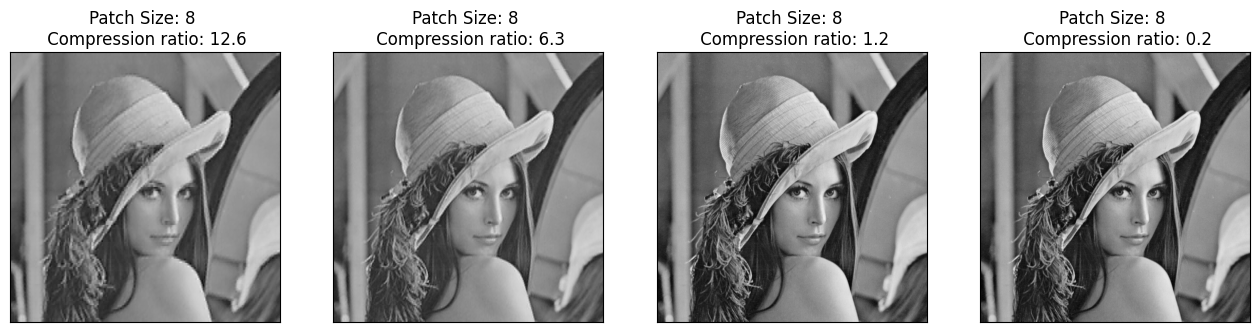

In [160]:
# 呼叫函數並傳遞不同的 patch_sz
compress_and_show_image(imgfile, 8)

 3. 同上，小圖大小為 16 $\times$ 16/per patch。

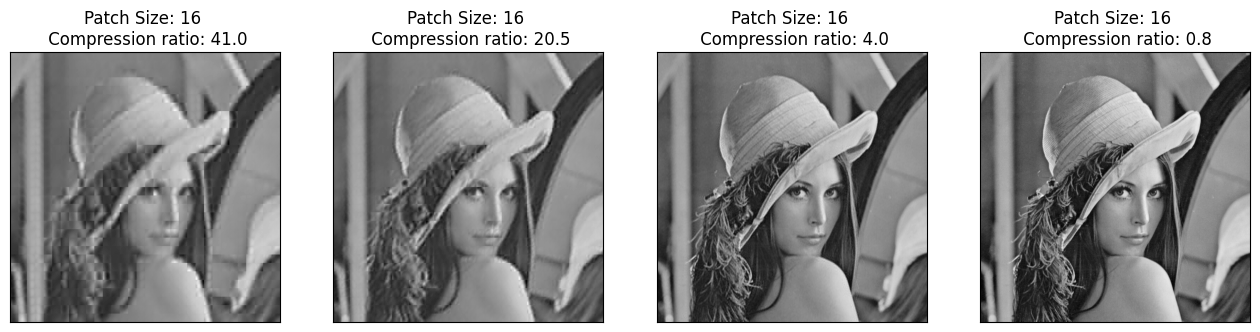

In [161]:
# 呼叫函數並傳遞不同的 patch_sz
compress_and_show_image(imgfile, 16)

 4. 同上，但分割成 32 $\times$ 32/per patch。

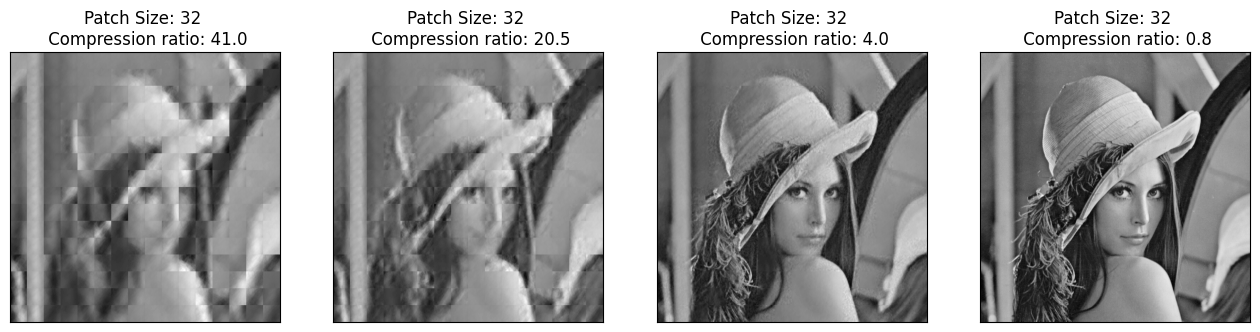

In [162]:
# 呼叫函數並傳遞不同的 patch_sz
compress_and_show_image(imgfile, 32)

 5. 其他方法 : 4 $\times$ 4 的 patch ，且移動步數為四格。

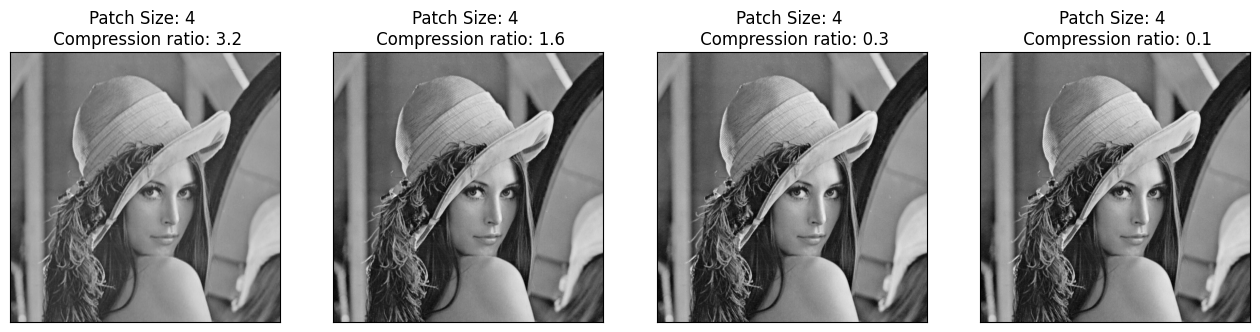

In [163]:
compress_and_show_image(imgfile, 4) 

- 從原圖觀察，當取的 Rank q Approximation 主成分越多時，越接近原圖影像。
- 如果有在 SVD 分解前加入切割圖像的步驟，當切割的區域越小時，在 Rank q Approximation 取小的時候效果越好。

<hr>

### 第二題
處理大量影像前，有必要觀看影像圖，以確定能掌握將要處理的影像及其資料型態。以 70000 張手寫圖像為例，每個數字約 7000 字，需要寫一段程式碼來觀察這些手寫數字的影像與品質，且每次執行都能隨機觀看到不同的影像，如下圖左（共兩排含 0~9 的數字各 50 個）與圖右的影像是兩次執行的結果。

請注意：隨機從某個數字抽取一定數量的影像，可以採「取後不放回」的方式，譬如 `np.random.choice(np.arange(N), replace=False, size=n)` 從 0 ~ N 的整數中隨機取 n 個。

<font color = yellow> 匯入手寫數字資料 <font>

In [164]:
# X, y = fetch_openml('mnist_784', return_X_y = True)
# X=X.T
#---------------------------------------------------
from sklearn.datasets import fetch_openml
import pickle
import os
data_file = 'data/mnist_digits_784.pkl'

# Check if data file exists
if os.path.isfile(data_file):
    # Load data from file
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
else:
    # Fetch data from internet
    data = fetch_openml('mnist_784', version=1, parser='auto')
    # Save data to file
    with open(data_file, 'wb') as f:
        pickle.dump(data, f)
        
X, y = np.array(data.data).T, np.array(data.target).astype('int')

<font color = yellow> 先指定要 X 中的第 1 張照片，再從 y 中挑選該數字的標籤與該數字標籤在 X 中的影像張數。 <font>

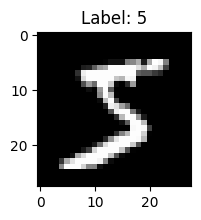

目標：第 0 張數字圖片
第0張數字圖片的數字(標籤) =  5
第0張數字圖片的數量為 6903


In [165]:
i = 0  # 第 i 張圖片，共有 70000 張圖片
img = X[:, i]
sz = np.sqrt(len(img)).astype('int')
fig = plt.figure(figsize=(2, 2))
plt.imshow(np.array(img).reshape(sz, sz), cmap='gray')
plt.title('Label: {}'.format(y[i]))
plt.show()

print('目標：第 {I} 張數字圖片'.format(I = i))
print('第{I}張數字圖片的數字(標籤) = '.format(I = i),y[i])  # print出第一張圖片的數字(標籤)  # y為一個70000 x 1的矩陣
print('第{I}張數字圖片的數量為'.format(I = i), sum(y==0))  # print出數字(標籤)為 5 的圖片有多少張

plt.show()

<font color = yellow> 用 y 指定數字 5 ，從中隨機抽出不放回 5 * 5 張的數字影像並拼接成蒙太奇矩陣。<font>

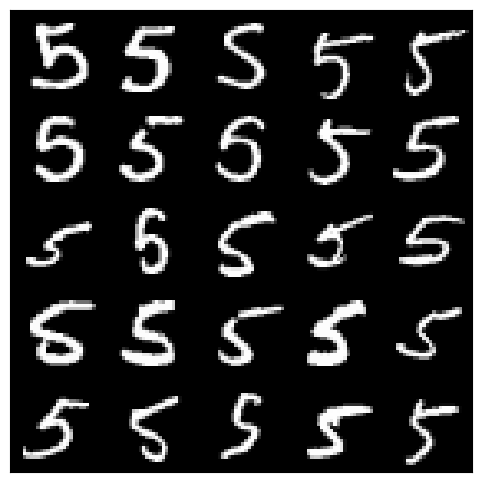

In [166]:
digit_to_show = 5
m, n = 5, 5 # A m x n montage (total mn images)
Digit = X[:, y==digit_to_show]
N = Digit.shape[1]
sample_indices = np.random.choice(np.arange(N), replace=False, size=m*n)

plt.figure(figsize = (6, 6))
sample_images = Digit[:, sample_indices]
M = montage(sample_images, m, n)
plt.imshow(M, cmap = 'gray', interpolation = 'nearest')
plt.xticks([])
plt.yticks([])
plt.show()

<font color = yellow> 一次抽出數字 0 到 9 各 5 * 5 張的樣本，抽出不放回樣本並抽取兩次觀察結果。<font>

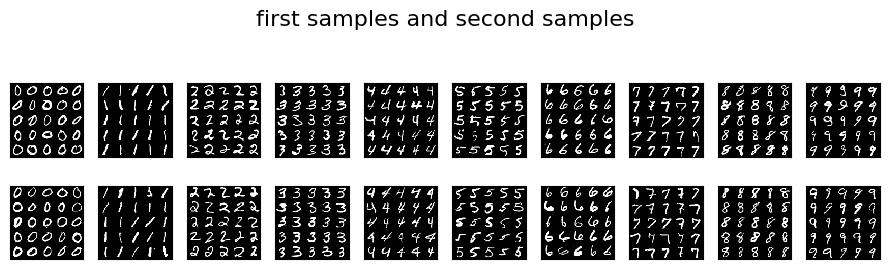

In [167]:
# 设置抽样的行列数
m, n = 5, 5
total_images = m * n

# 创建整个图
plt.figure(figsize=(9, 3))  # 设置整个图的尺寸

# 遍历每个数字
for digit_to_show in range(10):
    # 从 X 中筛选出标签为 digit_to_show 的样本
    Digit = X[:, y == digit_to_show]

    # 第一次抽样
    sample_indices = np.random.choice(np.arange(Digit.shape[1]), replace=False, size=total_images)
    sample_images = Digit[:, sample_indices]
    M = montage(sample_images, m, n)

    # 在第一行显示第一次抽样结果
    plt.subplot(2, 10, digit_to_show + 1)
    plt.imshow(M, cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# 遍历每个数字
for digit_to_show in range(10):
    # 从 X 中筛选出标签为 digit_to_show 的样本
    Digit = X[:, y == digit_to_show]

    # 第二次抽样
    sample_indices = np.random.choice(np.arange(Digit.shape[1]), replace=False, size=total_images)
    sample_images = Digit[:, sample_indices]
    M = montage(sample_images, m, n)

    # 在第二行显示第二次抽样结果
    plt.subplot(2, 10, digit_to_show + 11)
    plt.imshow(M, cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# 添加标题
plt.suptitle("first samples and second samples", fontsize=16)
plt.tight_layout()  # 调整子图布局，防止重叠
plt.show()

- 兩次分別抽取的結果不盡相同。

<hr>

### 第三題
每張大小 28×28 的手寫數字圖像 70000 張，不經壓縮前的儲存空間為 54.88 M Bytes。

若進行 SVD 的 “Rank q approximation”，則壓縮倍數由 q 決定。

寫一支程式，當調整 q 值時，可以算出壓縮的倍數，並同時顯示原圖與壓縮後還原的圖各 100 張做為比較（任選 100 張）。另外 q 的選擇可以根據 $\sigma_1$, $\sigma_2$, $\cdots$,  $\sigma_r$ 的「能量配置」來決定，或說決定 q 之後，可以計算所採用的主成分的能量佔比，本題也可以順便列印出這個佔比。

<font color = yellow> 取出 10 * 10 張不同數字的手寫影像並拼接成蒙太奇矩陣，當中每個數字的影像為 28 * 28。 <font>

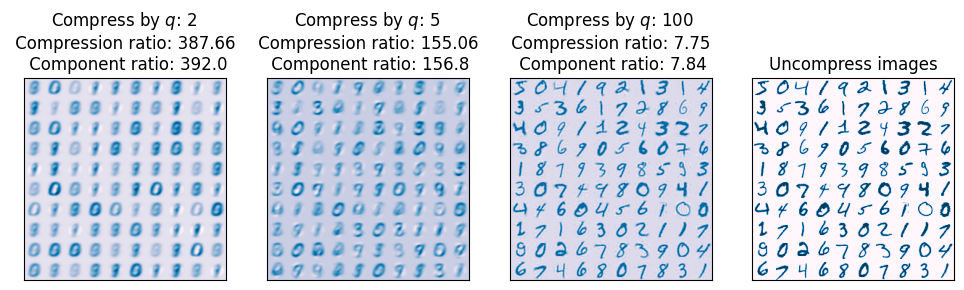

In [168]:
U, E, VT = svd(np.array(X), full_matrices = False) # 表示 Digit = U * E * V^T 其中 E 唸為 Sigma
q = np.array([2, 5, 100])
m, n = 10, 10
fig, ax = plt.subplots(1, len(q)+1, figsize = (12, 4))

for i, r in enumerate(q):
     orgsize = X.shape[0]*X.shape[1]
     componsize = q[i]*X.shape[0]
     compresssize = q[i]*X.shape[1]
     
     ratio = orgsize/(componsize+compresssize)
     compratio = orgsize/compresssize

     Xq = U[:, :r] @ np.diag(E[:r]) @ VT[:r, :] # X = U * E * VT
     # Xq = U[:, :r] @ (U[:, :r].T @ Digit[:, :m*n]) # Xq = Uq * (Uq)^T * X
     ax[i].imshow(montage(Xq, m, n), cmap = 'PuBu')
     ax[i].set_title('Compress by $q$: {} \n Compression ratio: {:.2f} \n Component ratio: {}'.format(q[i],ratio,compratio))
     ax[i].set_xticks([])
     ax[i].set_yticks([])

ax[3].imshow(montage(np.array(X),10,10), cmap = 'PuBu')
ax[3].set_title('Uncompress images')
ax[3].set_xticks([])
ax[3].set_yticks([])

plt.show()

- 當 Rank q Approximation 取的越大，取到 100 時，接近原圖的呈現。
- 當 q 取的小時，比較能辨別出的是數字 0。

<hr>

### 第四題
有 5 張經過加密的影像圖（2024年版壓縮檔下載），其加密的方式採 Yale Faces 38 人 2410 張人臉圖像矩陣 $X$ 的 SVD，即 $X = U\Sigma V^T$，取 $U$ 作為影像加密的工具，即假設向量 $x$ 代表一張原圖影像，則 $U[:, 0:q]^T x$ 代表該影像的前 q 個主成分，以此作為加密影像。請注意：這 5 張影像圖的主成分採 q=2000，矩陣 $X$ 先減去平均值，再執行 SVD 得到 $U$。

 1.請解密這 5 張影像。

In [169]:
def show_montage(X, n, m, h, w):
#X: 影 像 資 料 矩 陣 ， 每 行 代 表 一 張 影 像
#n, m: 每 張 影 像 的 大 小 n x m
#h, w : 建 立 一 個 蒙 太 奇 圖 陣 ， 大小 figsize = (w,h)
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: # 影 像 張 數 不 到 w x h 張 ， 用 0 向量補齊
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [170]:
D = scipy.io.loadmat('pictures/allFaces.mat')
X = D['faces'] # 32256 x 2410, each column represents an image
y = np.ndarray.flatten(D['nfaces'])
m = int(D['m']) # 168
n = int(D['n']) # 192
n_persons = int(D['person']) # 38

C:\Users\yangs\AppData\Local\Temp\ipykernel_20400\273467756.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(D['m']) # 168
C:\Users\yangs\AppData\Local\Temp\ipykernel_20400\273467756.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(D['n']) # 192
C:\Users\yangs\AppData\Local\Temp\ipykernel_20400\273467756.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_persons = int(D['person']) # 38


<font color = yellow> 此檔案當中具有 2410 張 192 * 168 像素的人臉影像。取出標籤為 person 的 38 張人臉圖，最後以蒙太奇圖拼接呈現作為初步觀察。 <font>

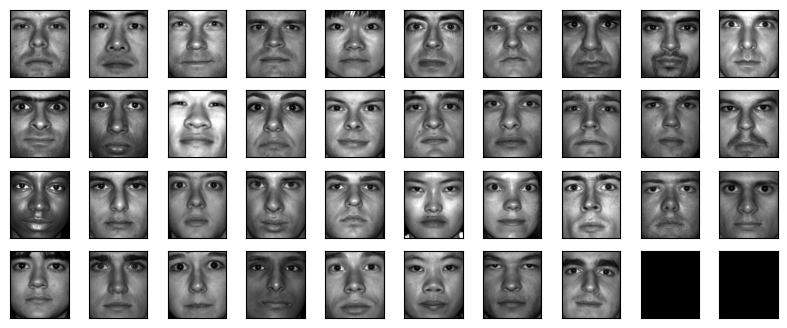

In [171]:
all_diff_persons = np.zeros((m*n, n_persons))
cnt = 0
for i in range(n_persons):
    all_diff_persons[:,i] = X[:,cnt]
    cnt = cnt + y[i]
show_montage(all_diff_persons , n, m, 4,10)

<font color = yellow> 並把 X 作為加密工具進行處理，取得 X 的變異後再進行 SVD 分解，即可得到能解壓縮的矩陣 U。 <font>

In [172]:
# avgFace = X.mean(axis = 1).reshape(-1,1)
# X_avg = X - np.title(avgFace, (1, X.shape[1]))
avgFace = X.mean(axis = 1)
X_avg = X - avgFace.reshape(-1,1)
U, E, VT = svd(X_avg,full_matrices = False)
#U, E, VT = svd(X, full_matrices = False)

#X = (32256,2410)
#U = (32256,2410),VT=(2410,2410)

<font color = yellow> 加密的影像五張呈現出來的效果都一樣，所以只呈現一張。將加密影像命名為 encryption_img。五張加密影像為一陣列，所以指標 iloc[:, 0] 為第一張影像，並將長寬設為 50 * 40 ，使得 Rank q Approximation 可以取至 2000。 <font>

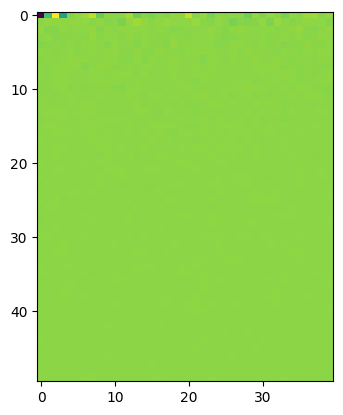

In [173]:
encryption_img = pd.read_csv('D:/shallow_ml/pictures/五張加密的影像_2024.csv')
plt.imshow(np.array(encryption_img.iloc[:, 0]).reshape((50, 40)))

<font color = yellow> 將用來解壓縮的矩陣 U ，取至 q = 2000。與加密影像進行矩陣相乘，則可得到解密後的影像。 <font>

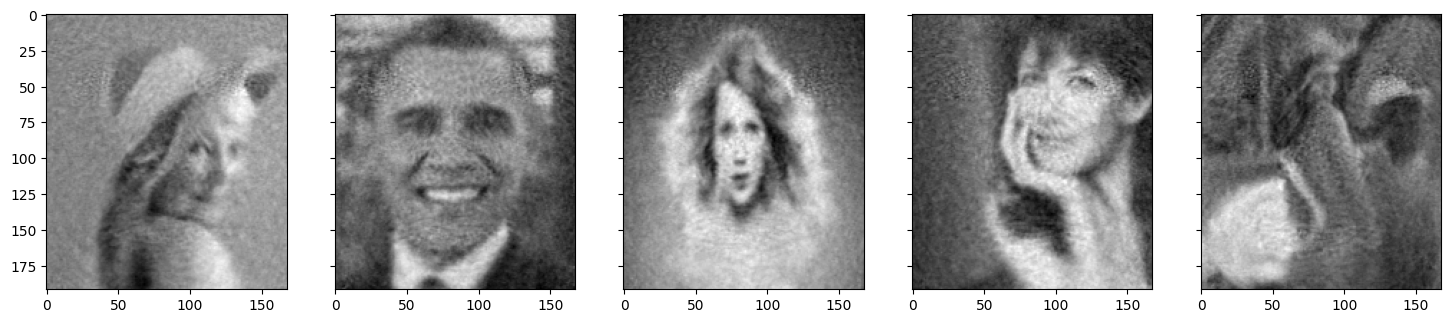

In [174]:
q=2000 #取原圖大小去解密
Xq=np.dot(U[:,0:q],encryption_img) # U[:,0:q]為解壓縮 
# Xq=np.dot(U[:,0:q],firstimage)
fig,ax=plt.subplots(1,5,figsize=(18,18),facecolor='white',sharey=True)
for i in range(5):
    ax[i].imshow(Xq[:,i].reshape(m,n).T,cmap='gray')

 2.自行找 5 張照片（大小必須同 Yale Faces 的 192×168 或自行 Resize），含人臉、水果、風景 … 等進行加密後（q 自選），再解密，觀察這些解密後的影像的效果，是否人臉的表現比較好？其他非人臉影像，如風景影像，能透過由人臉建構的特徵 $U$ 加密嗎？（即解密後能否看到原圖模樣？）

<font color = yellow> 五張照片以原圖呈現 <font>

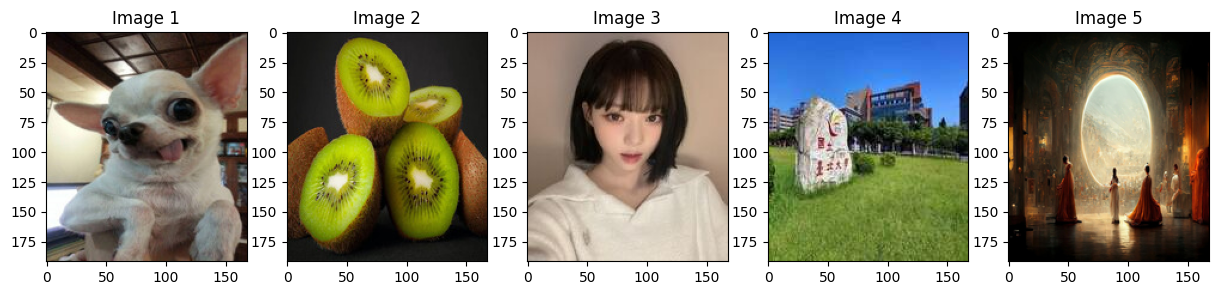

In [175]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Creating a figure with 1 row and 5 columns

img_files = [
    'D:\\shallow_ml\\pictures\\jiwawa.jpg',
    'D:\\shallow_ml\\pictures\\奇異果.jpg',
    'D:\\shallow_ml\\pictures\\winter.jpg',
    'D:\\shallow_ml\\pictures\\ntpu.jpg',
    'D:\\shallow_ml\\pictures\\aipic.jpg'
]

# Load images into variables X1 to X5
X1 = mpimg.imread(img_files[0])
X2 = mpimg.imread(img_files[1])
X3 = mpimg.imread(img_files[2])
X4 = mpimg.imread(img_files[3])
X5 = mpimg.imread(img_files[4])

for i, img in enumerate([X1, X2, X3, X4, X5]):
    axes[i].imshow(img)
    #axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f'Image {i+1}')
plt.show()


<font color = yellow> 將影像去除三原色的色階，方便進行矩陣計算。 <font>

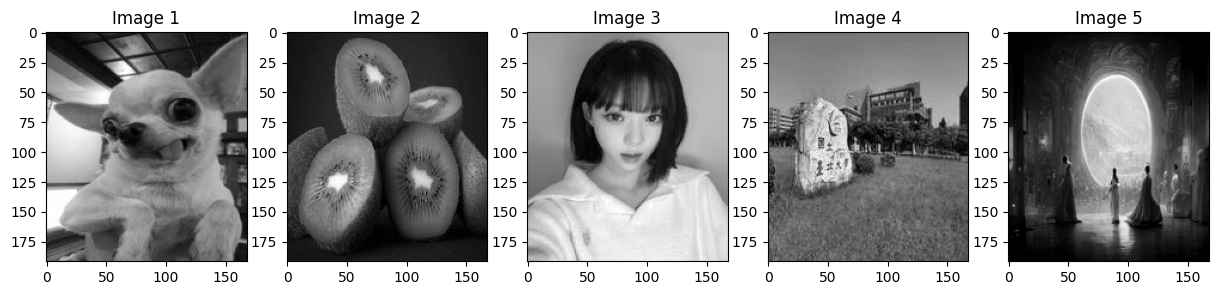

In [176]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, img in enumerate([X1, X2, X3, X4, X5]):
    if len(img.shape) > 2: #確認為二階以上rgb原彩
        img = np.mean(img, axis=2) 
    axes[i].imshow(img , cmap='gray') # convert RGB to grayscale
    axes[i].set_title(f'Image {i+1}')
plt.show()

In [177]:
# 無法再迴圈內將RGB色階去除
if len(X1.shape) > 2:
    X1 = np.mean(X1, axis=2)
if len(X2.shape) > 2:
    X2 = np.mean(X2, axis=2)
if len(X3.shape) > 2:
    X3 = np.mean(X3, axis=2)
if len(X4.shape) > 2:
    X4 = np.mean(X4, axis=2)
if len(X5.shape) > 2:
    X5= np.mean(X5, axis=2)

<font color = yellow> 先以自行找的人臉影像作為加密工具，應用在這五張影像進行解密。其 U[:,:d]@ (U[:,:d].T @ np.array(r)) 為還原 ( 解密 ) 的影像 Xq <font>

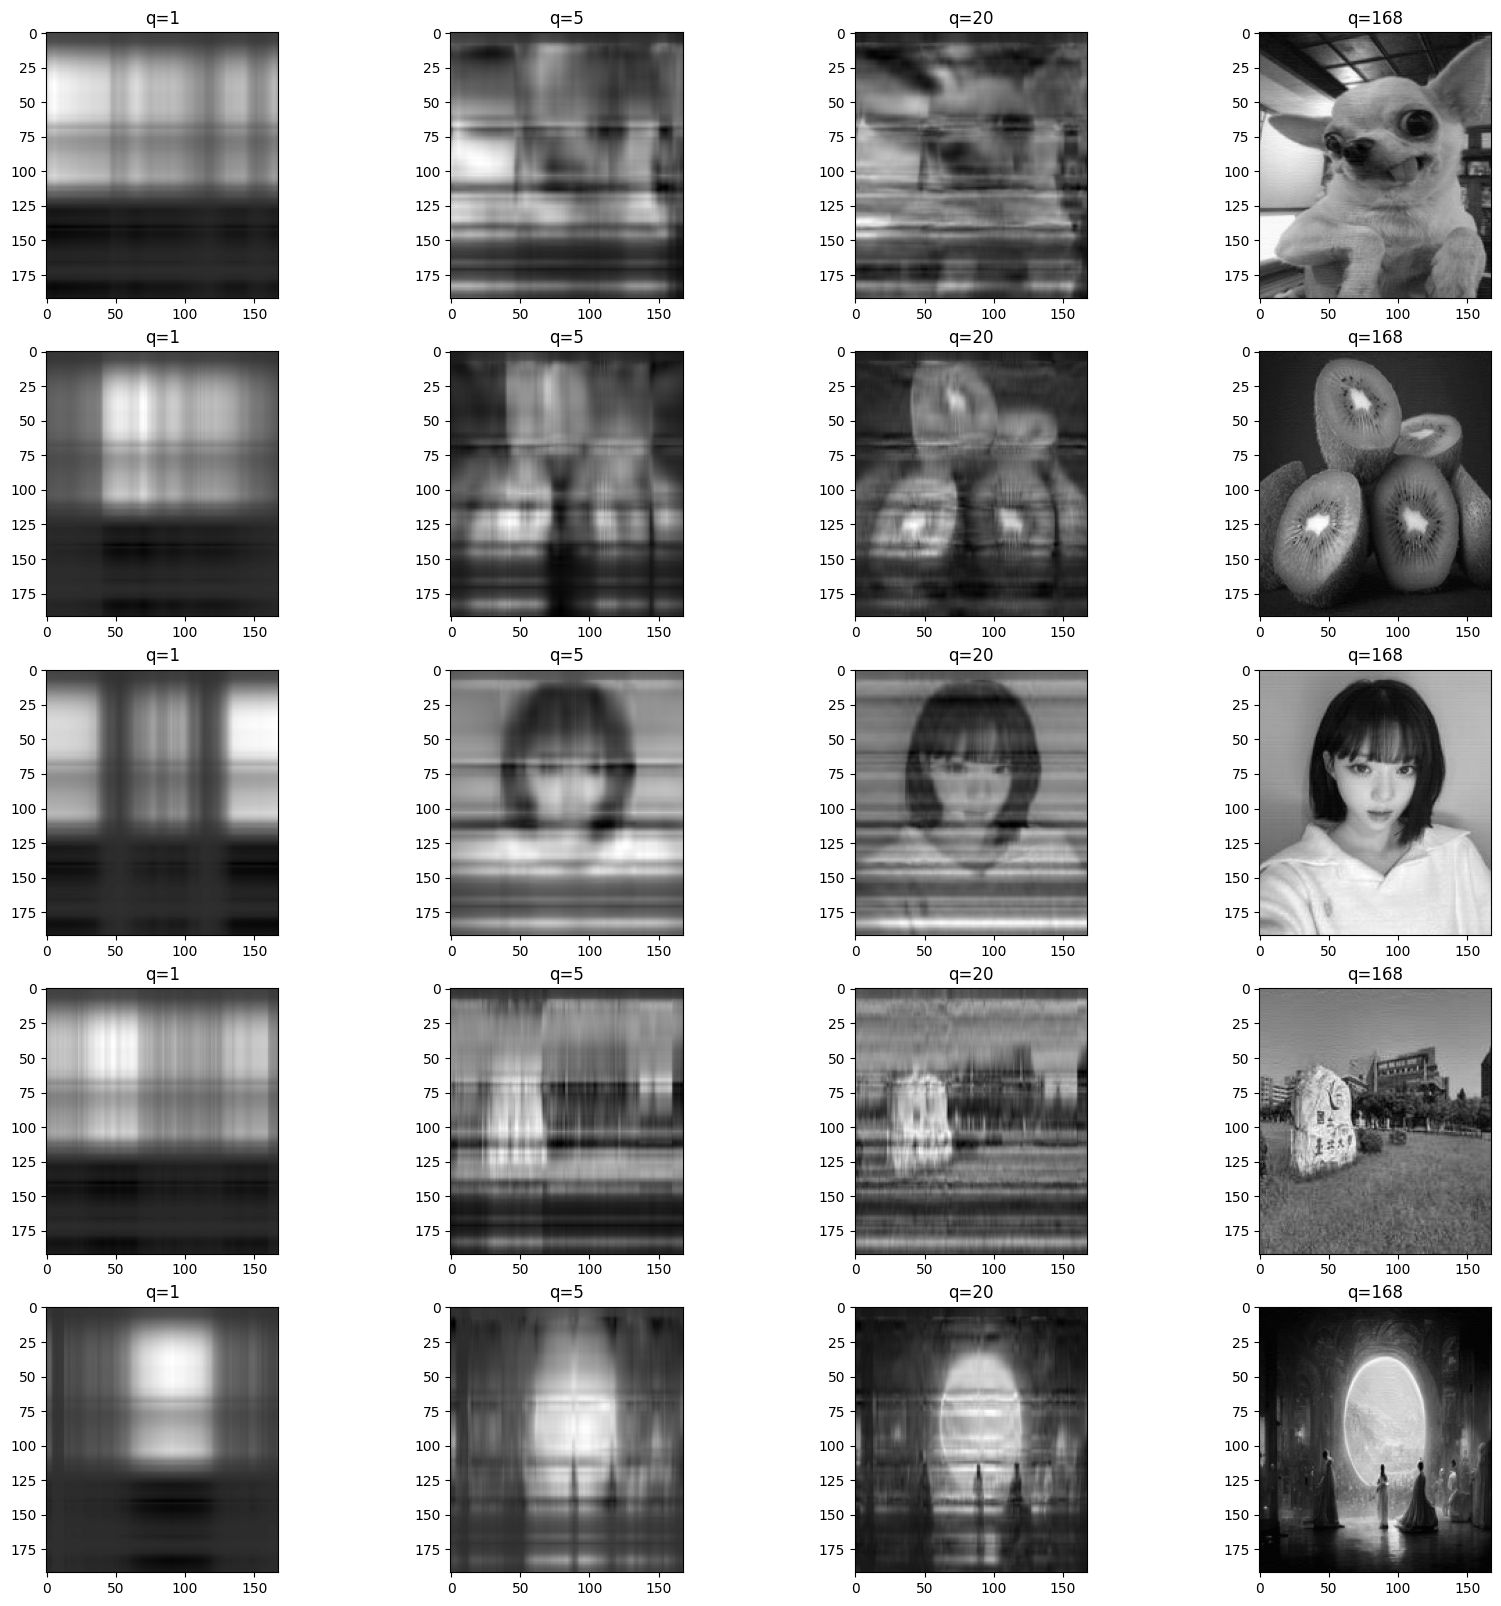

In [178]:
#加密步驟
avgFace = X3.mean(axis = 1)
X_avg = X3 - avgFace.reshape(-1,1)
U, E, VT = svd(X_avg,full_matrices = False)
q=np.array([1,5,20,168]).astype('int')

plt.figure(figsize=(20,20))
for i,r in enumerate([X1, X2, X3, X4, X5]):
    for w,d in enumerate(q):
        Xq = U[:,:d]@ (U[:,:d].T @ np.array(r)) #U[:,:d].T 為解壓縮 @ np.array(r) 五張加密圖
        plt.subplot(5,4,(i*len(q))+w+1)
        plt.title('q={}'.format(d))
        plt.imshow(Xq,cmap='gray')
plt.show()

<font color = yellow> 以風景影像作為加密工具 <font>

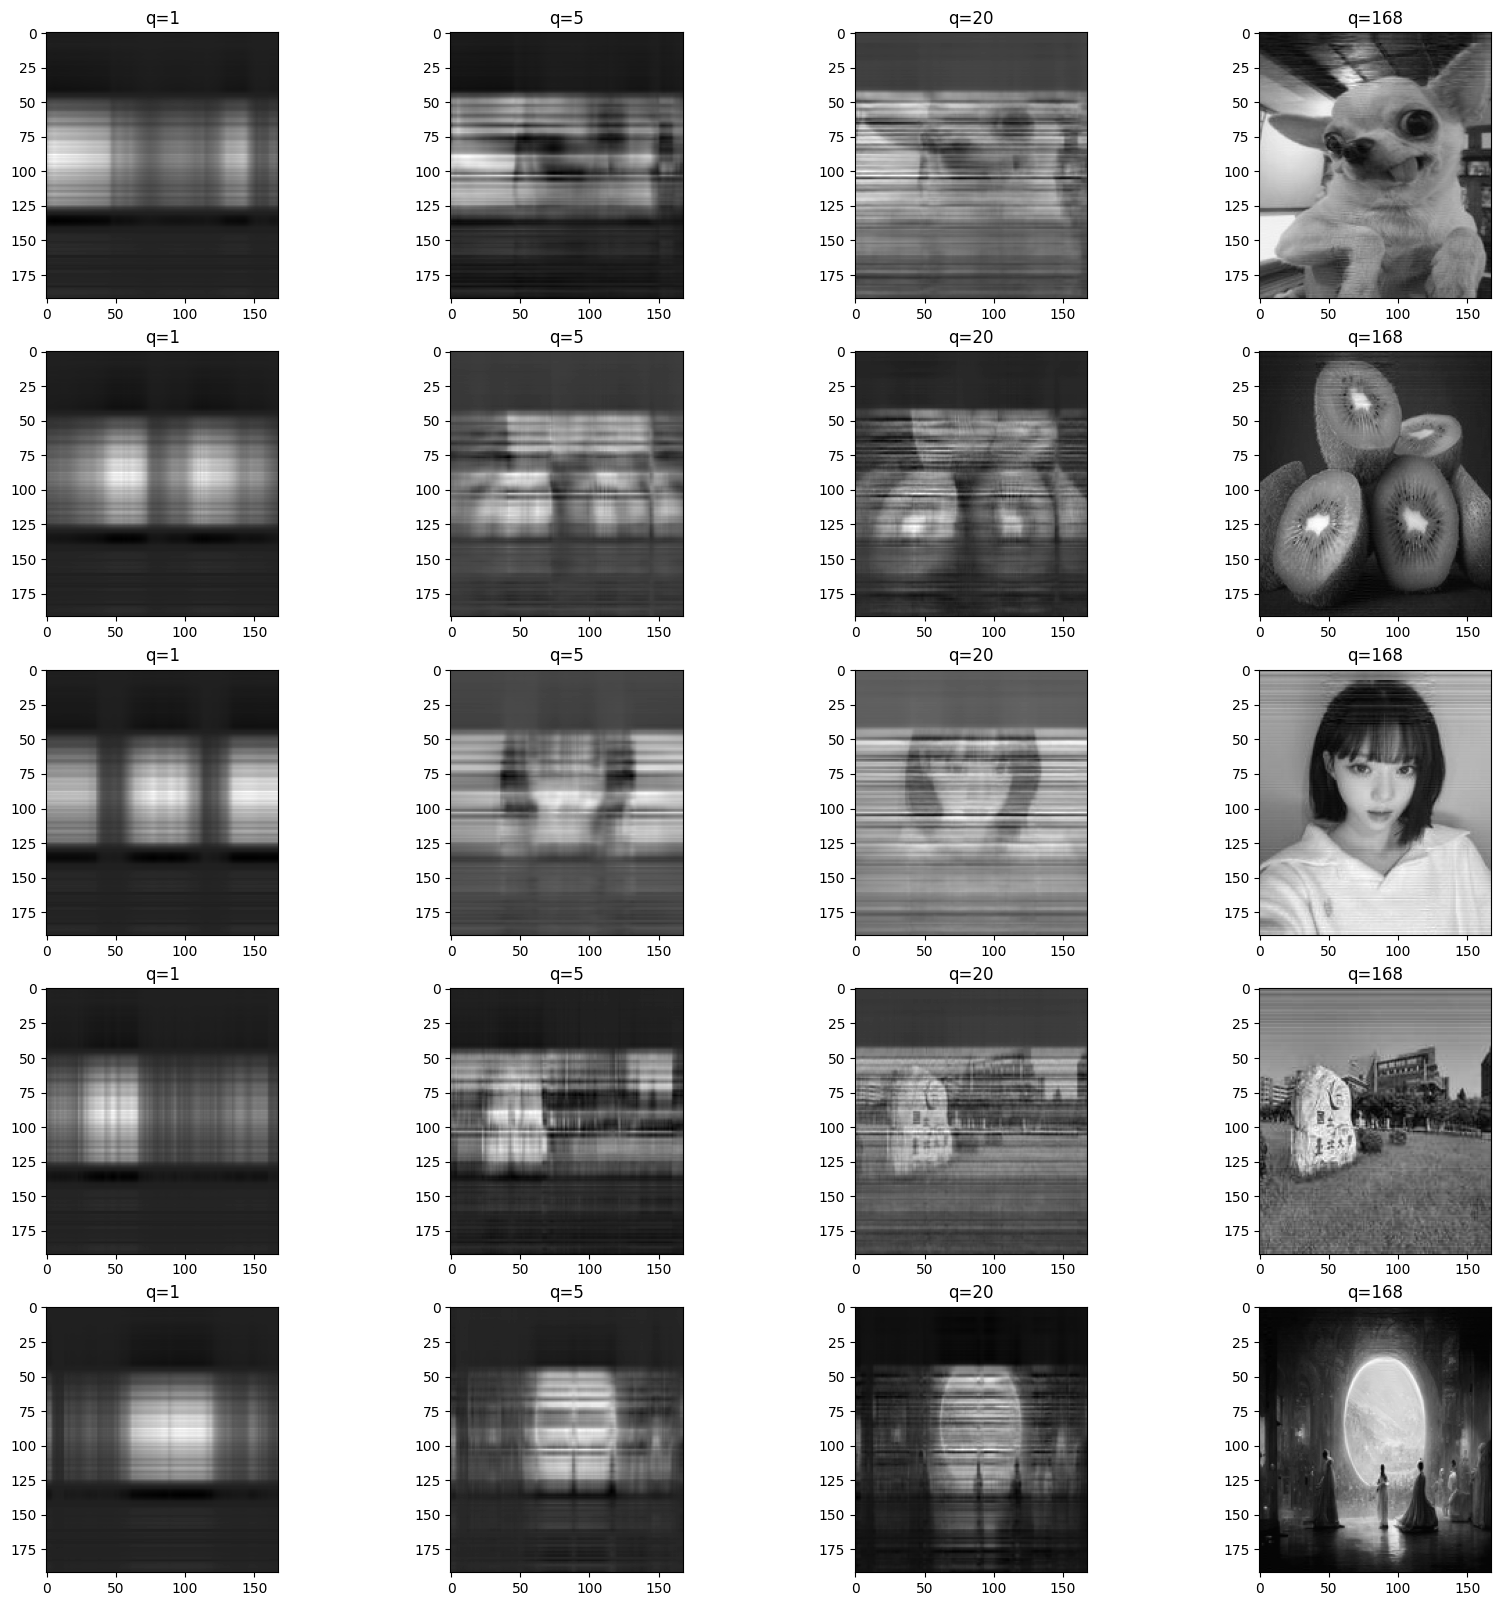

In [179]:
#加密步驟
avgFace = X4.mean(axis = 1)
X_avg = X4 - avgFace.reshape(-1,1)
U, E, VT = svd(X_avg,full_matrices = False)
q=np.array([1,5,20,168]).astype('int')

plt.figure(figsize=(20,20))
for i,r in enumerate([X1, X2, X3, X4, X5]):
    for w,d in enumerate(q):
        Xq =U[:,:d]@ (U[:,:d].T @ np.array(r)) #U[:,:d].T 為解壓縮 @ np.array(r) 五張加密圖
        plt.subplot(5,4,(i*len(q))+w+1)
        plt.title('q={}'.format(d))
        plt.imshow(Xq,cmap='gray')
plt.show()

- 以人臉影像作為加密工具，進行 SVD 解，其還原的效果應用在動物、水果、風景及 AI 生成的照片上，效果都還不錯。在 q 為 20 時就看得出原影像。
- 以風景照作為加密工具時，可以發現還原的影像具有缺失。即便還原接近原影像時，還是會發現小瑕疵 ( 影像上方黑區塊 )。